# DSA210 Term Project
## Behavioral and Attention-Based Signals Behind Bitcoin Price Direction

---

### Introduction

This notebook is prepared as part of the DSA210 term project.
The main goal is to analyze how behavioral and attention-based indicators
(such as social media activity, public attention, and investor psychology)
relate to Bitcoin’s short-term price direction.

In this notebook, I will:
- Load and explore the datasets
- Perform basic data cleaning
- Conduct exploratory data analysis (EDA) with visualizations
- Try simple machine learning models to test the main hypothesis

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

plt.style.use("seaborn-v0_8")
sns.set(font_scale=0.9)

pd.set_option("display.max_columns", 50)

## 1. Data Sources

The analysis is based on already preprocessed CSV files, generated through custom data-cleaning scripts:

### • `bitcoin_adjusted.csv`
Engineered Bitcoin dataset combining raw OHLCV data with additional technical indicators.
Created using **`adjust_btc_price.py`**, which extends the raw price series by computing:

- `Date`
- `Open`, `High`, `Low`, `Close`, `Volume`

**Derived features:**
- `Daily_Return` — percentage daily return
- `Log_Return` — logarithmic return
- `Volatility_7d` — 7-day rolling volatility
- `Momentum_3d` — 3-day momentum
- `MA_7` — 7-day moving average
- `Trend_Score` — simple trend indicator
- `Next_Day_Return` — next-day return
- `Target_Direction` — binary movement label (1 = up, 0 = down)

These engineered features were added because **raw Bitcoin price is not directly usable for prediction**, and a structured target variable is required for meaningful modeling.

---

### • `processed_tweets_final.csv`
Daily tweet-based sentiment features extracted from millions of raw tweets.
Generated using **`cleaning_tweets.py`** with the following logic:

- File was extremely large → **chunked processing** was required (`chunksize=50,000`) to avoid memory issues.
- Each tweet was cleaned, deduplicated, and analyzed with:
  - VADER sentiment
  - Bullish/bearish keyword dictionaries for intent classification
- Keyword-based tagging separates market optimism vs pessimism.
- The chunk-based tweet processing approach was implemented with support from an AI assistant to efficiently handle the large dataset.

**Final daily-level features:**
- `total_vol` — number of tweets per day
- `avg_sentiment` — weighted average sentiment
- `bull_ratio`, `bear_ratio` — proportion of bullish / bearish tweets
- `sentiment_spread` — bull_ratio − bear_ratio
- `sentiment_momentum` — day-to-day change in spread

---

### • `CryptoGreedFear.csv`
Official Crypto Fear & Greed Index:
- `date`
- `fng_value`
- `fng_classification` (Extreme Fear → Extreme Greed)

---

### • Google Trends CSVs
Downloaded monthly/weekly trend scores for Bitcoin and Crypto:

- `Bitcoin_web_trends.csv` → `btc_web`
- `Bitcoin_yt_trends.csv` → `btc_yt`
- `Crypto_web_trends.csv` → `crypto_web`
- `Crypto_yt_trends.csv` → `crypto_yt`

These values were later **converted to daily resolution** to align with price and sentiment data.



In [21]:
# Load Bitcoin engineered data
btc = pd.read_csv("bitcoin_adjusted.csv")
btc["Date"] = pd.to_datetime(btc["Date"])

# Load daily tweet sentiment features
tweets = pd.read_csv("processed_tweets_final.csv")
tweets["Date"] = pd.to_datetime(tweets["Date"])

# Load Fear & Greed Index
fng = pd.read_csv("CryptoGreedFear.csv")
fng["Date"] = pd.to_datetime(fng["date"])

# Load Google Trends – Bitcoin

btc_web = pd.read_csv("Bitcoin_web_trends.csv", header=None, names=["Date", "btc_web"])
btc_web["Date"] = pd.to_datetime(btc_web["Date"])

btc_yt = pd.read_csv("Bitcoin_yt_trends.csv", header=None, names=["Date", "btc_yt"])
btc_yt["Date"] = pd.to_datetime(btc_yt["Date"])

crypto_web = pd.read_csv("Crypto_web_trends.csv", header=None, names=["Date", "crypto_web"])
crypto_web["Date"] = pd.to_datetime(crypto_web["Date"])

crypto_yt = pd.read_csv("Crypto_yt_trends.csv", header=None, names=["Date", "crypto_yt"])
crypto_yt["Date"] = pd.to_datetime(crypto_yt["Date"])


def expand_monthly_to_daily(df, value_col):
    df = df.set_index("Date").resample("D").ffill()
    return df.reset_index()

btc_web = expand_monthly_to_daily(btc_web, "btc_web")
btc_yt = expand_monthly_to_daily(btc_yt, "btc_yt")
crypto_web = expand_monthly_to_daily(crypto_web, "crypto_web")
crypto_yt = expand_monthly_to_daily(crypto_yt, "crypto_yt")

# Align all datasets to the common date range
datasets = [btc, tweets, fng, btc_web, btc_yt, crypto_web, crypto_yt]

min_common_date = max(df["Date"].min() for df in datasets)
max_common_date = min(df["Date"].max() for df in datasets)

print("Common date range:", min_common_date.date(), "to", max_common_date.date())

btc = btc[(btc["Date"] >= min_common_date) & (btc["Date"] <= max_common_date)]
tweets = tweets[(tweets["Date"] >= min_common_date) & (tweets["Date"] <= max_common_date)]
fng = fng[(fng["Date"] >= min_common_date) & (fng["Date"] <= max_common_date)]
btc_web = btc_web[(btc_web["Date"] >= min_common_date) & (btc_web["Date"] <= max_common_date)]
btc_yt = btc_yt[(btc_yt["Date"] >= min_common_date) & (btc_yt["Date"] <= max_common_date)]
crypto_web = crypto_web[(crypto_web["Date"] >= min_common_date) & (crypto_web["Date"] <= max_common_date)]
crypto_yt = crypto_yt[(crypto_yt["Date"] >= min_common_date) & (crypto_yt["Date"] <= max_common_date)]


Common date range: 2021-02-05 to 2023-01-09


## 2. Exploratory Data Analysis (EDA)

In this section, time series plots and distributions are used to explore:

- Bitcoin price and daily returns
- Tweet volume and sentiment indicators
- Fear & Greed index dynamics
- Google Trends for Bitcoin and crypto


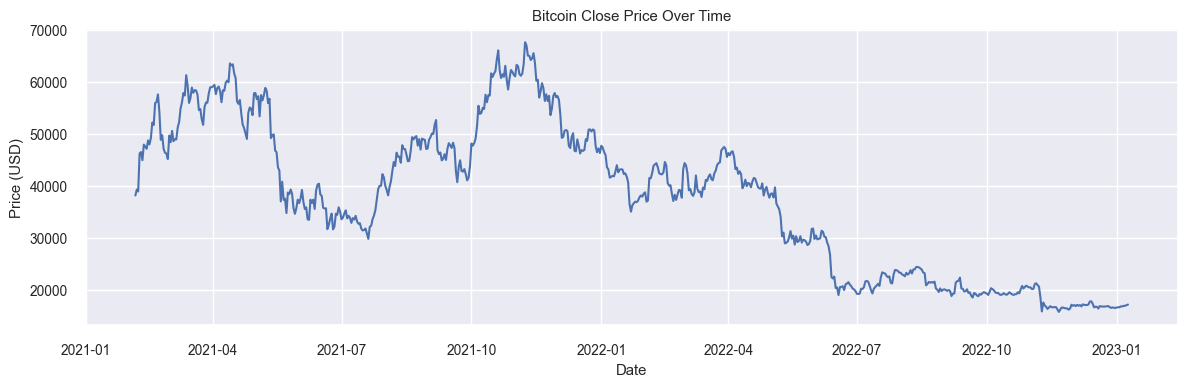

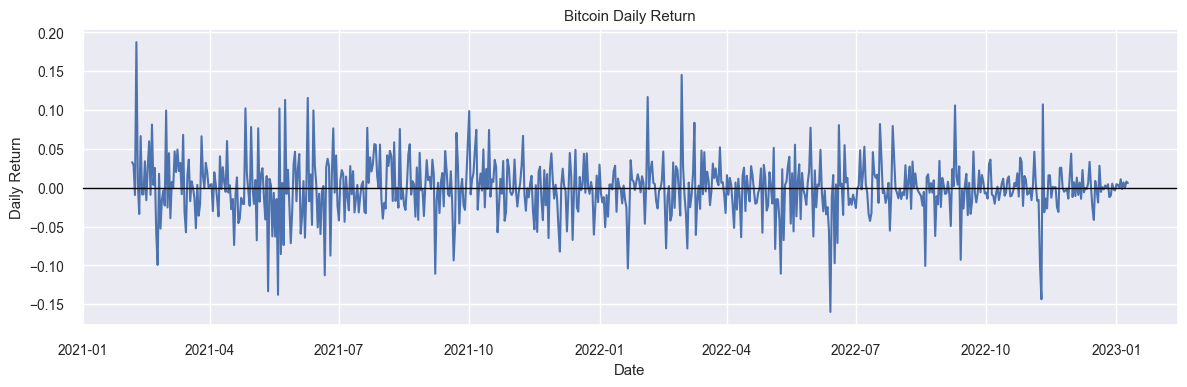

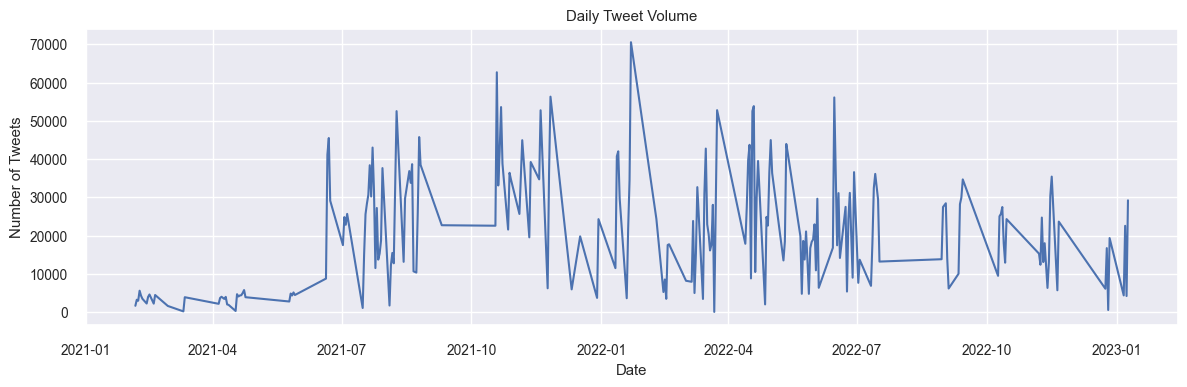

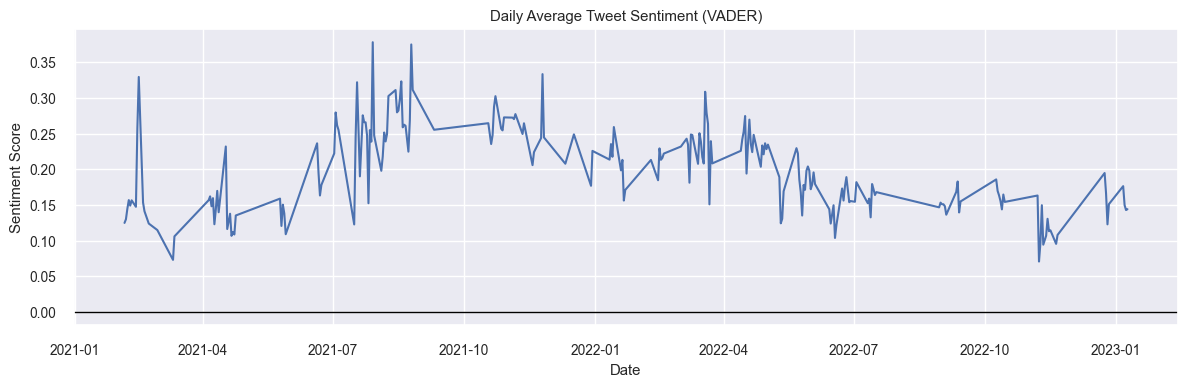

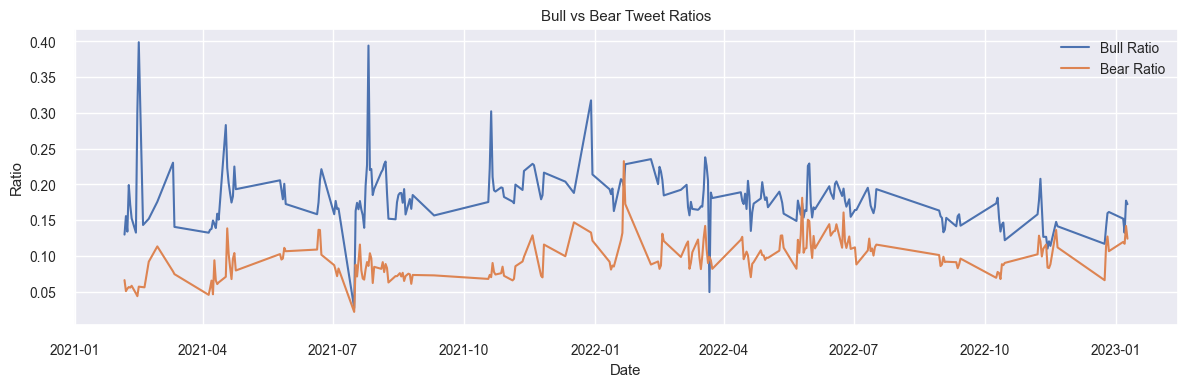

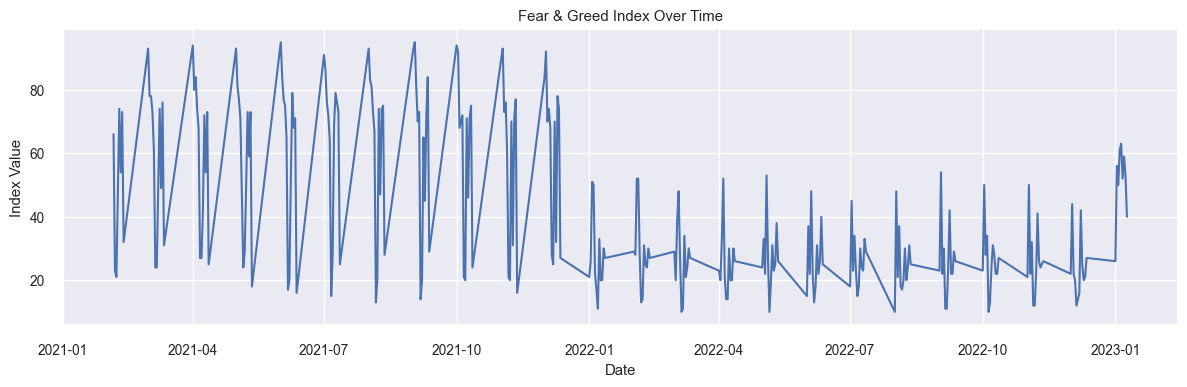

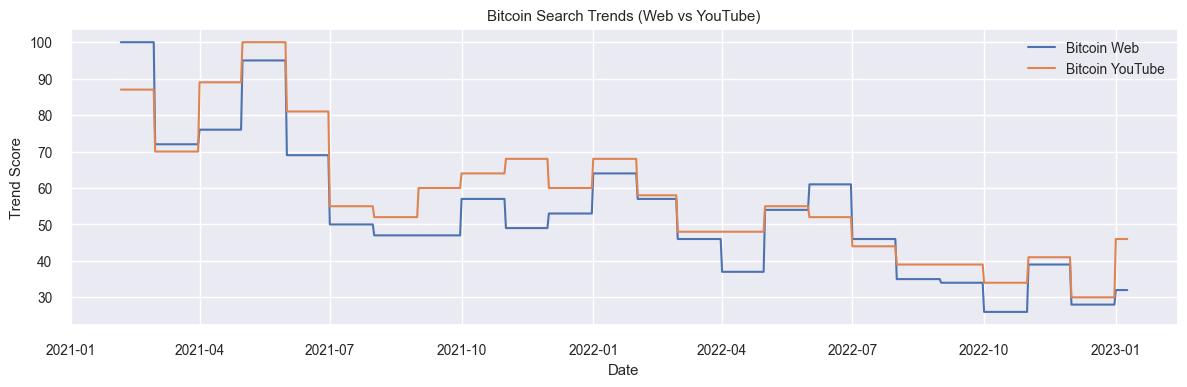

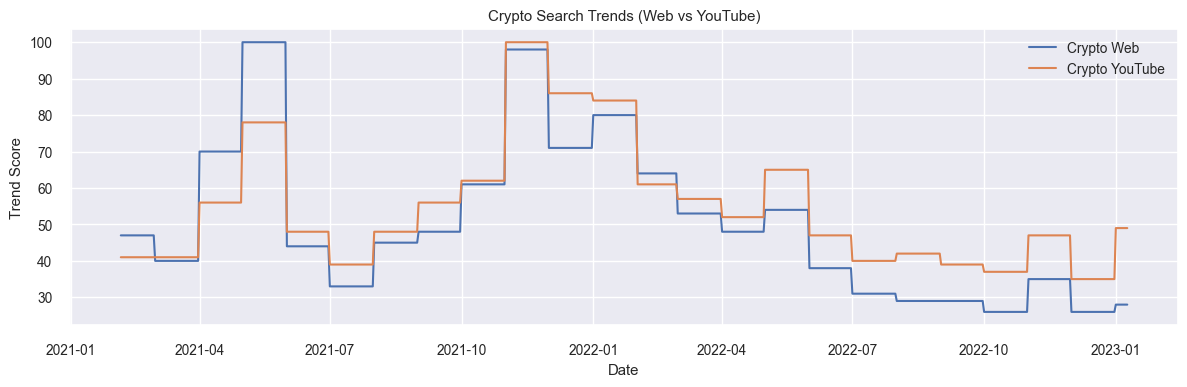

In [23]:
# Bitcoin Close Price
plt.figure(figsize=(12, 4))
plt.plot(btc["Date"], btc["Close"])
plt.title("Bitcoin Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()

# Bitcoin Daily Return
if "Daily_Return" in btc.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(btc["Date"], btc["Daily_Return"])
    plt.axhline(0, color="black", linewidth=1)
    plt.title("Bitcoin Daily Return")
    plt.xlabel("Date")
    plt.ylabel("Daily Return")
    plt.tight_layout()
    plt.show()

# Daily Tweet Volume
plt.figure(figsize=(12, 4))
plt.plot(tweets["Date"], tweets["total_vol"])
plt.title("Daily Tweet Volume")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

# Daily Average Sentiment
plt.figure(figsize=(12, 4))
plt.plot(tweets["Date"], tweets["avg_sentiment"])
plt.axhline(0, color="black", linewidth=1)
plt.title("Daily Average Tweet Sentiment (VADER)")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()

# Bull vs Bear Ratios
plt.figure(figsize=(12, 4))
plt.plot(tweets["Date"], tweets["bull_ratio"], label="Bull Ratio")
plt.plot(tweets["Date"], tweets["bear_ratio"], label="Bear Ratio")
plt.title("Bull vs Bear Tweet Ratios")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.legend()
plt.tight_layout()
plt.show()

# Fear & Greed Index
plt.figure(figsize=(12, 4))
plt.plot(fng["Date"], fng["fng_value"])
plt.title("Fear & Greed Index Over Time")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.tight_layout()
plt.show()

# Bitcoin Search Trends
plt.figure(figsize=(12, 4))
plt.plot(btc_web["Date"], btc_web["btc_web"], label="Bitcoin Web")
plt.plot(btc_yt["Date"], btc_yt["btc_yt"], label="Bitcoin YouTube")
plt.title("Bitcoin Search Trends (Web vs YouTube)")
plt.xlabel("Date")
plt.ylabel("Trend Score")
plt.legend()
plt.tight_layout()
plt.show()

# Crypto Search Trends
plt.figure(figsize=(12, 4))
plt.plot(crypto_web["Date"], crypto_web["crypto_web"], label="Crypto Web")
plt.plot(crypto_yt["Date"], crypto_yt["crypto_yt"], label="Crypto YouTube")
plt.title("Crypto Search Trends (Web vs YouTube)")
plt.xlabel("Date")
plt.ylabel("Trend Score")
plt.legend()
plt.tight_layout()
plt.show()


# 3.Summary of Visual Findings

### Bitcoin Price & Returns
Bitcoin’s closing price shows strong volatility with clear boom–bust cycles.
Daily returns fluctuate around zero, highlighting the unpredictable nature of short-term price movements.

---

### Tweet Volume & Sentiment
Tweet activity varies sharply and appears event-driven.
Average sentiment remains mostly positive, consistent with the general optimism in crypto communities.

---

### Bull vs Bear Ratios
Bullish tweets consistently outnumber bearish tweets.
Bearish spikes align with market drops, suggesting reactive—not predictive—behavior.

---

### Fear & Greed Index
The index shows frequent swings between fear and greed phases, reflecting strong emotional cycles among investors.

---

### Google Trends (Web & YouTube)
Step-like flat regions occur because Google Trends provides **weekly or bi-weekly** values instead of daily data.
For alignment in analysis, trend values were **converted to daily frequency** using forward-fill.


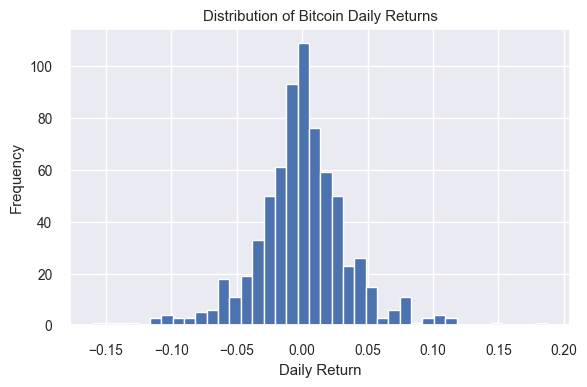

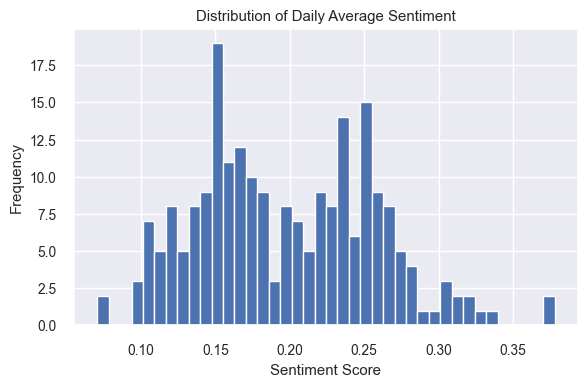

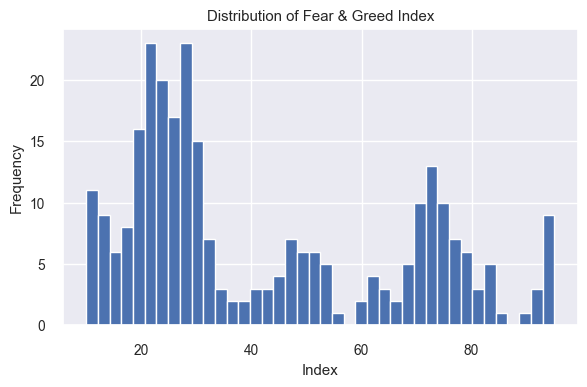

In [24]:
# Distribution of daily returns
if "Daily_Return" in btc.columns:
    plt.figure(figsize=(6, 4))
    plt.hist(btc["Daily_Return"].dropna(), bins=40)
    plt.title("Distribution of Bitcoin Daily Returns")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Distribution of daily average sentiment
plt.figure(figsize=(6, 4))
plt.hist(tweets["avg_sentiment"].dropna(), bins=40)
plt.title("Distribution of Daily Average Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Distribution of Fear & Greed index
plt.figure(figsize=(6, 4))
plt.hist(fng["fng_value"].dropna(), bins=40)
plt.title("Distribution of Fear & Greed Index")
plt.xlabel("Index")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 4.Distribution Insights

**Bitcoin Daily Returns:**
Returns cluster tightly around zero but show long tails on both sides. This indicates high volatility and the presence of occasional extreme positive or negative return days.

**Daily Average Tweet Sentiment:**
Sentiment scores are mostly concentrated in the positive zone, suggesting that Twitter discussions around Bitcoin are generally optimistic, with fewer strongly negative days.

**Fear & Greed Index:**
The index displays a wide and multi-modal distribution, reflecting recurring shifts between “extreme fear” and “extreme greed” periods in the crypto market.

Overall, the distributions show that Bitcoin exhibits strong volatility, social sentiment tends to stay mildly positive, and investor psychology oscillates across a broad emotional spectrum.


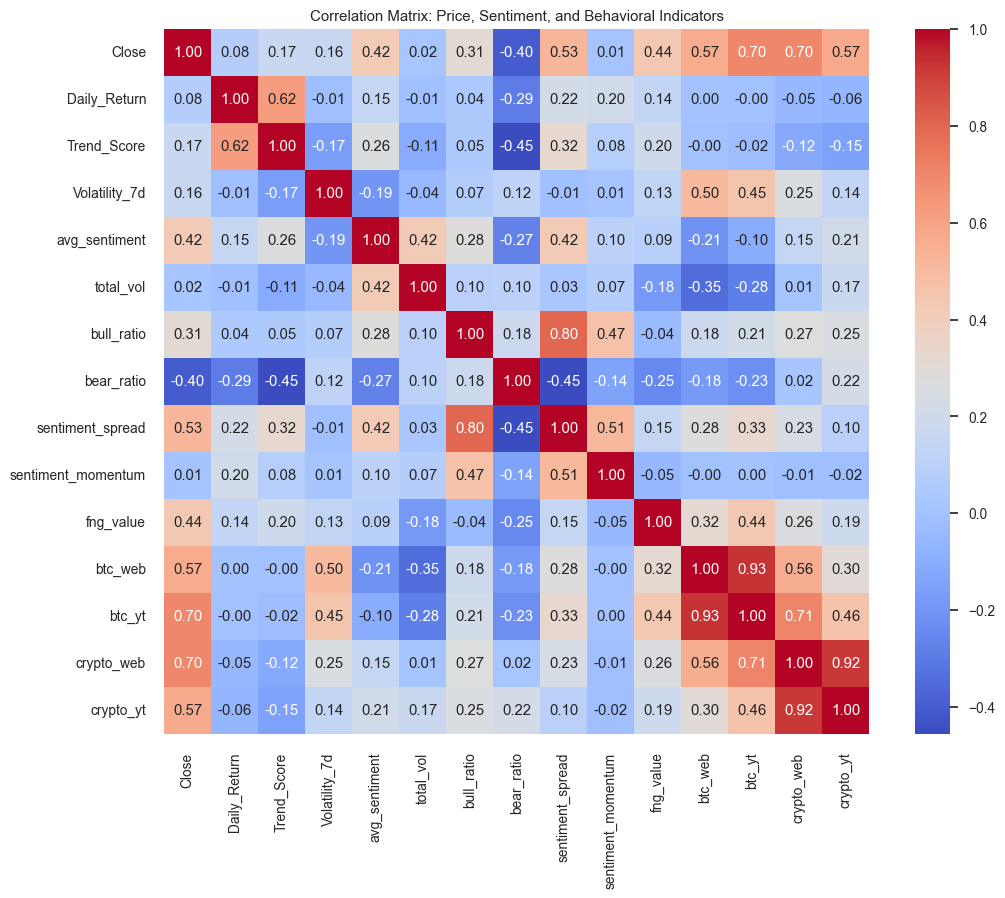

In [25]:
# Merge all datasets into a single analysis DataFrame
df = btc[["Date", "Close", "Daily_Return", "Trend_Score", "Volatility_7d"]].copy()

df = df.merge(
    tweets[
        [
            "Date",
            "avg_sentiment",
            "total_vol",
            "bull_ratio",
            "bear_ratio",
            "sentiment_spread",
            "sentiment_momentum",
        ]
    ],
    on="Date",
    how="left",
)

df = df.merge(fng[["Date", "fng_value"]], on="Date", how="left")
df = df.merge(btc_web, on="Date", how="left")
df = df.merge(btc_yt, on="Date", how="left")
df = df.merge(crypto_web, on="Date", how="left")
df = df.merge(crypto_yt, on="Date", how="left")

# Save merged data for hypothesis tests
df.to_csv("merged_data.csv", index=False)

# Correlation heatmap
corr = df.select_dtypes("number").corr()

plt.figure(figsize=(11, 9))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix: Price, Sentiment, and Behavioral Indicators")
plt.tight_layout()
plt.show()


## 5.Correlation Analysis

The heatmap highlights a few key patterns:

- **Google Trends metrics (btc_web, btc_yt, crypto_yt)** show the **strongest positive correlation** with Bitcoin price. Search interest moves closely with market cycles.
- **Tweet sentiment features (avg_sentiment, bull_ratio, sentiment_spread)** show **weak or near-zero correlation** with returns, indicating that daily Twitter mood does not meaningfully predict short-term price movements.
- **Bearish activity (bear_ratio)** has a **mild negative correlation** with price, aligning with market downturn periods.
- **Fear & Greed Index** correlates moderately with price, but does not provide strong predictive power.
- Social features correlate strongly with each other (e.g., bull_ratio ↔ sentiment_spread), confirming internal consistency but limited market impact.

Overall, behavioral metrics reflect general market regimes rather than providing daily predictive signals.


## 6. Hypothesis Testing

This section formally tests whether social media and sentiment related variables are associated with:

- Next-day Bitcoin returns
- The difference between up days and down days


In [29]:
# Use the merged DataFrame df created above
ht_df = df.copy()

# Next day return for predictive correlation tests
ht_df["Next_Return"] = ht_df["Daily_Return"].shift(-1)

# Binary variable: 1 if today's return is positive
ht_df["Price_Up"] = (ht_df["Daily_Return"] > 0).astype(int)

# Drop rows with NaN created by shift
ht_df = ht_df.dropna()


# ================================
# 1. CORRELATION TESTS
# ================================

print("=== Correlation tests (Pearson) ===")

corr_tests = [
    ("avg_sentiment", "Next_Return", "Sentiment vs Next Return"),
    ("sentiment_spread", "Next_Return", "Sentiment Spread vs Next Return"),
    ("bull_ratio", "Next_Return", "Bull Ratio vs Next Return"),
    ("bear_ratio", "Next_Return", "Bear Ratio vs Next Return"),
    ("fng_value", "Next_Return", "Fear & Greed vs Next Return"),
    ("total_vol", "Volatility_7d", "Tweet Volume vs Volatility_7d"),
]

for x, y, label in corr_tests:
    test_df = ht_df[[x, y]].dropna()
    if len(test_df) < 3:
        continue
    r, p = stats.pearsonr(test_df[x], test_df[y])
    print(f"{label:35s}  r = {r:7.3f},  p = {p:.4f}")

print()


# ================================
# 2. MEAN DIFFERENCE TESTS
# ================================

print("=== Mean difference tests (Up days vs Down days) ===\n")

up = ht_df[ht_df["Price_Up"] == 1]
down = ht_df[ht_df["Price_Up"] == 0]

mean_tests = [
    ("avg_sentiment", "Average Sentiment"),
    ("sentiment_spread", "Sentiment Spread"),
    ("bull_ratio", "Bull Ratio"),
    ("bear_ratio", "Bear Ratio"),
    ("fng_value", "Fear & Greed Index"),
]

for var, label in mean_tests:
    up_vals = up[var].dropna()
    down_vals = down[var].dropna()

    if len(up_vals) < 3 or len(down_vals) < 3:
        continue

    t_stat, t_p = stats.ttest_ind(up_vals, down_vals, equal_var=False)
    u_stat, u_p = stats.mannwhitneyu(up_vals, down_vals, alternative="two-sided")

    print(f"{label}:")
    print(f"  Up days   mean = {up_vals.mean():.4f}")
    print(f"  Down days mean = {down_vals.mean():.4f}")
    print(f"  T-test p-value       = {t_p:.4f}")
    print(f"  Mann-Whitney p-value = {u_p:.4f}\n")


=== Correlation tests (Pearson) ===
Sentiment vs Next Return             r =  -0.053,  p = 0.6571
Sentiment Spread vs Next Return      r =   0.070,  p = 0.5553
Bull Ratio vs Next Return            r =  -0.059,  p = 0.6183
Bear Ratio vs Next Return            r =  -0.167,  p = 0.1585
Fear & Greed vs Next Return          r =   0.033,  p = 0.7804
Tweet Volume vs Volatility_7d        r =   0.004,  p = 0.9706

=== Mean difference tests (Up days vs Down days) ===

Average Sentiment:
  Up days   mean = 0.1885
  Down days mean = 0.1802
  T-test p-value       = 0.5205
  Mann-Whitney p-value = 0.4530

Sentiment Spread:
  Up days   mean = 0.0885
  Down days mean = 0.0734
  T-test p-value       = 0.0313
  Mann-Whitney p-value = 0.0658

Bull Ratio:
  Up days   mean = 0.1733
  Down days mean = 0.1668
  T-test p-value       = 0.2985
  Mann-Whitney p-value = 0.5299

Bear Ratio:
  Up days   mean = 0.0848
  Down days mean = 0.0934
  T-test p-value       = 0.1139
  Mann-Whitney p-value = 0.1034

Fear & G

## 7. Discussion and Limitations

- Correlation and mean difference results indicate whether sentiment and behavioral indicators carry any signal for Bitcoin's daily returns.
- The analysis is purely observational and does not prove causality.
- Sentiment is derived from Twitter text using VADER and simple keyword dictionaries, which may not fully capture the complexity of crypto slang and context.
- Only one asset (Bitcoin) and a specific time window are considered, so results may not generalize to other coins or other market regimes.
